Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.6.1

torch 1.2.0


- Runs on CPU or GPU (if available)

# Deep Convolutional GAN

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings and Dataset

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 42
generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x



##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [4]:
##########################
### MODEL
##########################

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Reshape1(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)


class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
              
            nn.Linear(LATENT_DIM, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            Reshape1(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            #nn.Dropout2d(p=0.2),
            
            Flatten(),

            nn.Linear(7*7*32, 1),
            #nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)




In [5]:
torch.manual_seed(random_seed)

#del model
model = GAN()
model = model.to(device)

print(model)

GAN(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace=True)
    (3): Reshape1()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.0001, inplace=True)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.0001, inplace=True)
    (13): ConvTranspose2d(8, 

In [6]:
### ## FOR DEBUGGING

"""
outputs = []
def hook(module, input, output):
    outputs.append(output)

#for i, layer in enumerate(model.discriminator):
#    if isinstance(layer, torch.nn.modules.conv.Conv2d):
#        model.discriminator[i].register_forward_hook(hook)

for i, layer in enumerate(model.generator):
    if isinstance(layer, torch.nn.modules.ConvTranspose2d):
        model.generator[i].register_forward_hook(hook)
"""

'\noutputs = []\ndef hook(module, input, output):\n    outputs.append(output)\n\n#for i, layer in enumerate(model.discriminator):\n#    if isinstance(layer, torch.nn.modules.conv.Conv2d):\n#        model.discriminator[i].register_forward_hook(hook)\n\nfor i, layer in enumerate(model.generator):\n    if isinstance(layer, torch.nn.modules.ConvTranspose2d):\n        model.generator[i].register_forward_hook(hook)\n'

In [7]:
optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

## Training

In [8]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        # Normalize images to [-1, 1] range
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 

        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        

        ### FORWARD AND BACK PROP
        
        
        # --------------------------
        # Train Generator
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28))
        
        gener_loss = F.binary_cross_entropy_with_logits(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        discr_pred_real = model.discriminator_forward(features.view(targets.size(0), 1, 28, 28))
        real_loss = F.binary_cross_entropy_with_logits(discr_pred_real, valid)
        
        discr_pred_fake = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28).detach())
        fake_loss = F.binary_cross_entropy_with_logits(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
        
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.7042/0.6743
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 1.3058/0.3250
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 1.4384/0.2663
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 1.6195/0.2611
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 1.5340/0.3022
Time elapsed: 0.19 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 1.1456/0.4471
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 1.1290/0.4476
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 1.0849/0.4651
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 1.0275/0.4765
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 0.9861/0.4893
Time elapsed: 0.37 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 0.9710/0.5148
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 0.9321/0.5574
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 0.9129/0.5724
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 0.9706/0.5348
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 0.9026/0.5425
Time elapsed: 0.57 min
Epoch: 004/100 |

In [9]:
### For Debugging

"""
for i in outputs:
    print(i.size())
"""

'\nfor i in outputs:\n    print(i.size())\n'

## Evaluation

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

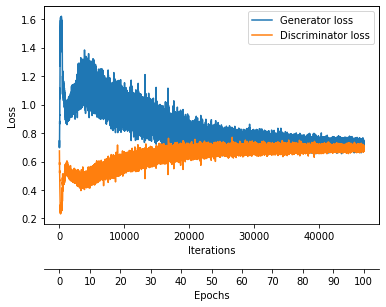

In [11]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.show()

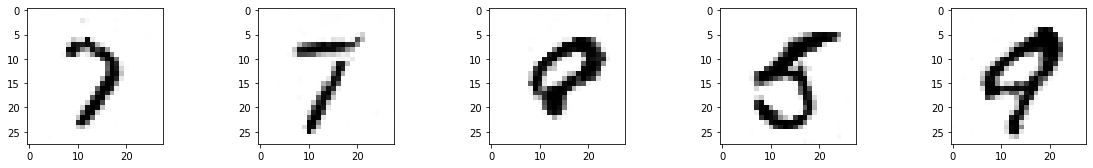

In [12]:
##########################
### VISUALIZATION
##########################


model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')

In [13]:
from torchsummary import summary
model = model.to('cuda:0')
summary(model.generator, input_size=(100,))
summary(model.discriminator, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         313,600
       BatchNorm1d-2                 [-1, 3136]           6,272
         LeakyReLU-3                 [-1, 3136]               0
          Reshape1-4             [-1, 64, 7, 7]               0
   ConvTranspose2d-5           [-1, 32, 13, 13]          18,432
       BatchNorm2d-6           [-1, 32, 13, 13]              64
         LeakyReLU-7           [-1, 32, 13, 13]               0
   ConvTranspose2d-8           [-1, 16, 25, 25]           4,608
       BatchNorm2d-9           [-1, 16, 25, 25]              32
        LeakyReLU-10           [-1, 16, 25, 25]               0
  ConvTranspose2d-11            [-1, 8, 27, 27]           1,152
      BatchNorm2d-12            [-1, 8, 27, 27]              16
        LeakyReLU-13            [-1, 8, 27, 27]               0
  ConvTranspose2d-14            [-1, 1,